In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('C:/Users/flath/Desktop/Rec.sis/retail_train.csv')
item_features = pd.read_csv('C:/Users/flath/Desktop/Rec.sis/product.csv')
user_features = pd.read_csv('C:/Users/flath/Desktop/Rec.sis/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


In [3]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


## Make cold-start to warm-start

In [6]:
# ищем общих пользователей
common_users = data_train_lvl_1.user_id.values

data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]


## Задание 1.

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?

Пока пробуем отобрать 50 кандидатов (k=50) Качество измеряем на data_val_matcher: следующие 6 недель после трейна Дают ли own recommendtions + top-popular лучший recall?

B) Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500} C) Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [7]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [8]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [9]:
N_PREDICT = 500

In [11]:
%%time
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_lvl_1['sim_item_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
pop = list(recommender.top_purchases.item_id[:N_PREDICT])
result_lvl_1['pop_rec'] = result_lvl_1['user_id'].apply(lambda x: pop)
result_lvl_1['own+pop_rec'] = result_lvl_1['own_rec'] + result_lvl_1['pop_rec']
result_lvl_1['own_rec+sim_item_rec'] = result_lvl_1['own_rec'] + result_lvl_1['sim_item_rec']

Wall time: 48.2 s


In [12]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [13]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

## Recall@50 of matching

In [14]:
TOPK_RECALL = 50

In [16]:
sorted(calc_recall(result_lvl_1, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('own+pop_rec', 0.06525657038145175),
 ('own_rec+sim_item_rec', 0.06525657038145175),
 ('als_rec', 0.04895602283263726),
 ('sim_item_rec', 0.033983422610524644),
 ('pop_rec', 0.021002732977743847)]

In [18]:
def recall_at_kk_own(data, kk):
  results = []
  for k in kk:
    results.append(data.apply(lambda row: recall_at_k(row['own_rec'], row['actual'], k=k), axis=1).mean())
  plt.plot(kk,results)

In [19]:
examples = [i for i in range(5,500, 30)]

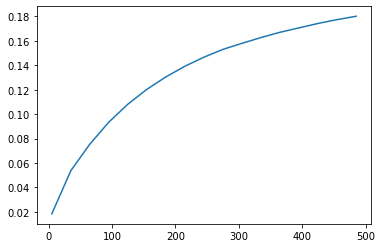

In [20]:
recall_at_kk_own(result_lvl_1, examples)

## Precision@5 of matching

In [21]:
TOPK_PRECISION = 5

In [22]:
sorted(calc_precision(result_lvl_1, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('own+pop_rec', 0.17712691771268974),
 ('own_rec+sim_item_rec', 0.17712691771268974),
 ('als_rec', 0.1168758716875863),
 ('sim_item_rec', 0.059972105997211034),
 ('pop_rec', 0.013110181311018099)]

## Задание 2.

Обучите модель 2-ого уровня, при этом:

Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

Вырос ли precision@5 при использовании двухуровневой модели?

In [23]:
df_match_candidates = pd.DataFrame(data_train_lvl_2['user_id'].unique())
df_match_candidates.columns = ['user_id']

In [24]:
N_PREDICT = 50

In [25]:
df_match_candidates['candidates'] = df_match_candidates['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [26]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [27]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [28]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [29]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


## Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1

In [32]:
df_ranker_train = data_train_lvl_2[['user_id', 'item_id']].copy()
df_ranker_train['target'] = 1 

In [33]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [34]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=['user_id', 'item_id'], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=['user_id', 'item_id'])

df_ranker_train['target'].fillna(0, inplace= True)

In [35]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [36]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


In [37]:
df_ranker_train['target'].mean()

0.07286953595333358

## Подготавливаем фичи для обучения модели

In [38]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [39]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [40]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106972 entries, 0 to 106971
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               106972 non-null  int64  
 1   item_id               106972 non-null  int64  
 2   target                106972 non-null  float64
 3   manufacturer          106972 non-null  int64  
 4   department            106972 non-null  object 
 5   brand                 106972 non-null  object 
 6   commodity_desc        106972 non-null  object 
 7   sub_commodity_desc    106972 non-null  object 
 8   curr_size_of_product  106972 non-null  object 
 9   age_desc              39519 non-null   object 
 10  marital_status_code   39519 non-null   object 
 11  income_desc           39519 non-null   object 
 12  homeowner_desc        39519 non-null   object 
 13  hh_comp_desc          39519 non-null   object 
 14  household_size_desc   39519 non-null   object 
 15  

In [41]:
pd.options.display.max_columns = None

In [42]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [43]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['user_id','manufacturer'],as_index=False)['item_id'].count(), on=['user_id','manufacturer'], how='left')
df_ranker_train = df_ranker_train.rename({'item_id_y': 'user_id_manufacturer_freq','item_id_x' : 'item_id' }, axis='columns')

In [44]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['user_id','department'],as_index=False)['item_id'].count(), on=['user_id','department'], how='left')
df_ranker_train = df_ranker_train.rename({'item_id_y': 'user_department_freq','item_id_x' : 'item_id' }, axis='columns')

In [45]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['item_id','department'],as_index=False)['user_id'].count(), on=['item_id','department'], how='left')
df_ranker_train = df_ranker_train.rename({'user_id_y': 'item_department_freq','user_id_x' : 'user_id' }, axis='columns')

In [46]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['age_desc', 'item_id'],as_index=False)['user_id'].count(), on=['age_desc', 'item_id'], how='left')
df_ranker_train = df_ranker_train.rename({'user_id_y': 'age_desc_item_freq','user_id_x' : 'user_id' }, axis='columns')

In [47]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['department', 'brand','user_id'],as_index=False)['item_id'].count(), on=['department', 'brand','user_id'], how='left')
df_ranker_train = df_ranker_train.rename({'item_id_y': 'brand_pop','item_id_x' : 'item_id' }, axis='columns')

In [48]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['income_desc','item_id'],as_index=False)['user_id'].count(), on=['income_desc','item_id'], how='left')
df_ranker_train = df_ranker_train.rename({'user_id_y': 'money_pop','user_id_x' : 'user_id' }, axis='columns')

In [49]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106972 entries, 0 to 106971
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    106972 non-null  int64  
 1   item_id                    106972 non-null  int64  
 2   target                     106972 non-null  float64
 3   manufacturer               106972 non-null  int64  
 4   department                 106972 non-null  object 
 5   brand                      106972 non-null  object 
 6   commodity_desc             106972 non-null  object 
 7   sub_commodity_desc         106972 non-null  object 
 8   curr_size_of_product       106972 non-null  object 
 9   age_desc                   39519 non-null   object 
 10  marital_status_code        39519 non-null   object 
 11  income_desc                39519 non-null   object 
 12  homeowner_desc             39519 non-null   object 
 13  hh_comp_desc               39

In [50]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id_manufacturer_freq,user_department_freq,item_department_freq,age_desc_item_freq,brand_pop,money_pop
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14,4,26,4.0,2,3.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1,34,46,7.0,25,8.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14,6,8,2.0,2,2.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1,6,269,50.0,4,39.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14,6,12,2.0,2,2.0


In [51]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [52]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_id_manufacturer_freq',
 'user_department_freq',
 'item_department_freq',
 'age_desc_item_freq',
 'brand_pop',
 'money_pop']

## Обучение модели ранжирования

In [55]:
from lightgbm import LGBMClassifier

In [56]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,

                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [57]:
df_ranker_predict = df_ranker_train.copy()

In [58]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [59]:
df_ranker_predict['proba_item_purchase'][:10]

0    0.051373
1    0.016169
2    0.056515
3    0.001174
4    0.418403
5    0.044226
6    0.038103
7    0.001453
8    0.144729
9    0.402968
Name: proba_item_purchase, dtype: float64

Мы обучили модель ранжирования на покупках из сета data_train_lvl_2  и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

## Оценка тестового набора данных

In [60]:
result_eval_ranker = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker.columns=['user_id', 'actual']
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [61]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 8.25 s


In [62]:
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.

In [63]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [64]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker['user_id'].apply(lambda user_id: rerank(user_id))

In [65]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1767101827676222)
('own_rec', 0.1444117647058813)


C:\Users\flath\Downloads\src\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
